In [1]:
from HotVisFunctions import *
import csv

In [2]:
def stress_loss(layout: torch.nn.Embedding|torch.Tensor, shortest_path_dist):
    loss = 0

    if isinstance(layout, torch.nn.Embedding):
        for i in range(layout.num_embeddings):
            for j in range(i + 1, layout.num_embeddings):
                delta = layout(torch.tensor(i)) - layout(torch.tensor(j))
                distance = torch.norm(delta)
                loss += ((distance - shortest_path_dist[i, j])/shortest_path_dist[i, j]) ** 2  

    else:
        for i in range(layout.shape[0]):
            for j in range(i + 1, layout.shape[0]):
                delta = layout[i] - layout[j]
                distance = torch.norm(delta)
                loss += ((distance - shortest_path_dist[i, j])/shortest_path_dist[i, j]) ** 2  

    return loss


def SGD_stress_torch(data: pp.TemporalGraph|pp.PathData, iterations: int, delta: int = 1, learning_rate: float = 0.01, initial_positions: torch.Tensor | None = None):

    # Hier noch PathData version einfügen
    graph = data

    dist, _ = pp.algorithms.temporal_shortest_paths(graph, delta)

    # Fehlt: initial positions

    # initialize embedding
    num_nodes =  graph.N 
    embedding_dim = 2     
    embedding = torch.nn.Embedding(num_nodes, embedding_dim)

    if not initial_positions is None:
        with torch.no_grad(): 
            embedding.weight = torch.nn.Parameter(initial_positions)
    else:
        initial_positions = torch.rand((graph.N, 2))*100
        embedding.weight = torch.nn.Parameter(initial_positions)


    # define optimizer and lossfunction
    optimizer = torch.optim.SGD(embedding.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    for i in range(iterations):
        loss = stress_loss(embedding, dist)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Fortschritt anzeigen
        if (i) % 10 == 0:
            print(f"Epoch [{i+1}/{iterations}], Loss: {loss.item():.4f}")

    layout = {}
    for node in graph.nodes:
        layout[node] = embedding(torch.tensor(graph.mapping.to_idx(node))).tolist()

    return layout


In [7]:
def SGD_stress_paper(data: pp.TemporalGraph|pp.PathData, iterations: int, delta:int = 1, initial_positions: torch.Tensor | None = None, learning_rate: float = 0.01, eta: float = 1, decay: float = 0.2):
    # Hier noch PathData version einfügen
    graph = data

    dist, _ = pp.algorithms.temporal_shortest_paths(graph, delta)

    if initial_positions is None:
        initial_positions = torch.rand((graph.N, 2))*100
    
    positions = torch.clone(initial_positions)

    edges = torch.tensor([[graph.mapping.to_idx(i), graph.mapping.to_idx(j)] for i, j in graph.edges])

    for i in range(iterations):
        shuffled_edges = edges[torch.randperm(edges.size(0))]
        step_width = eta * torch.exp(torch.tensor(-decay * i))

        for edge in shuffled_edges:
            shortest_path_dist = dist[edge[0], edge[1]]
            if(shortest_path_dist == 0):
               continue
            learning_rate = min(1, ((1 / (shortest_path_dist ** 2)) * step_width)) / 2
            norm = torch.norm(positions[edge[0]] - positions[edge[1]])
            delta = (norm - shortest_path_dist) / norm * (positions[edge[0]] - positions[edge[1]])
            positions[edge[0]] -= learning_rate * delta
            positions[edge[1]] += learning_rate * delta

        # Fortschritt anzeigen
        if (i) % 10 == 0:
            print(f"Epoch [{i+1}/{iterations}], Stress: {stress_loss(positions, dist):.4f}")

    layout = {}
    for node in graph.nodes:
        layout[node] = positions[graph.mapping.to_idx(node)].tolist()

    return layout

In [8]:
graph = pp.io.read_csv_temporal_graph('graphs/synthetic_graph/temporal_clusters_real_kregular.tedges', is_undirected = True, timestamp_format='%S')
# read colors
colors = {}
with open('graphs/synthetic_graph/colors.csv', mode="r") as file:
    reader = csv.reader(file)
    next(reader)  # Überspringt die Kopfzeile
    for row in reader:
        number, color = row
        colors[number] = color
style = {}
style['node_color'] = colors
style['node_size'] = 10
style['edge_size'] = 0.1

In [9]:
layout_paper = SGD_stress_paper(graph, iterations=1000, delta = 1, learning_rate=0.001)
layout_torch = SGD_stress_torch(graph, iterations=1000, delta = 1, learning_rate=0.001)

100%|██████████| 20000/20000 [00:13<00:00, 1527.71it/s]


Epoch [1/1000], Stress: 96.5522
Epoch [11/1000], Stress: 68.9130
Epoch [21/1000], Stress: 67.1776
Epoch [31/1000], Stress: 66.8792
Epoch [41/1000], Stress: 66.8734
Epoch [51/1000], Stress: 66.8707
Epoch [61/1000], Stress: 66.8571
Epoch [71/1000], Stress: 66.8567
Epoch [81/1000], Stress: 66.8567
Epoch [91/1000], Stress: 66.8567
Epoch [101/1000], Stress: 66.8567
Epoch [111/1000], Stress: 66.8567
Epoch [121/1000], Stress: 66.8567
Epoch [131/1000], Stress: 66.8567
Epoch [141/1000], Stress: 66.8567
Epoch [151/1000], Stress: 66.8567
Epoch [161/1000], Stress: 66.8567
Epoch [171/1000], Stress: 66.8567
Epoch [181/1000], Stress: 66.8567
Epoch [191/1000], Stress: 66.8567
Epoch [201/1000], Stress: 66.8567
Epoch [211/1000], Stress: 66.8567
Epoch [221/1000], Stress: 66.8567
Epoch [231/1000], Stress: 66.8567
Epoch [241/1000], Stress: 66.8567


KeyboardInterrupt: 

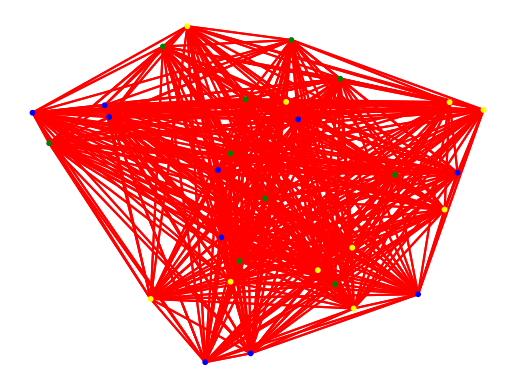

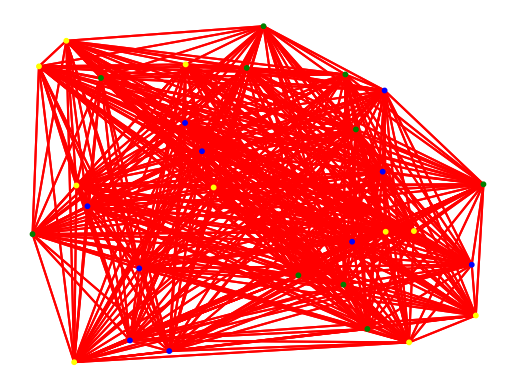

In [ ]:
pp.plot(graph.to_static_graph(), layout=layout_torch, backend='matplotlib', **style)
pp.plot(graph.to_static_graph(), layout=layout_paper, backend='matplotlib', **style)